In [ ]:
import numpy as np
import PIL.Image
import glob
import os

In [ ]:
IMAGE_SIZE = (150, 400, 3)
DATASET_PATH = "./dataset/"
DATASET_PATH = os.path.abspath(DATASET_PATH)
CLASSES = glob.glob(f"{DATASET_PATH}/*")
CLASSES = list(map(lambda f: f.split("/")[-1], CLASSES))

print(DATASET_PATH)
print(CLASSES)

In [ ]:
def load_data():
    # Récupération des fichiers
    files = glob.glob(f"{DATASET_PATH}/**/*.jpg", recursive = True)

    # Initialise les structures de données
    x = np.zeros((len(files), *IMAGE_SIZE))
    y = np.zeros((len(files), 1))

    for i, path in enumerate(files):
        # Lecture de l'image
        img = PIL.Image.open(path)
        
        # Remplissage de la variable x
        x[i] = np.asarray(img)

        # On récupère l'index dans le path
        class_label = path.split("/")[-2]

        # On récupère le numéro de la classe à partir du string
        class_label = CLASSES.index(class_label)
        
        # Remplissage de la variable y
        y[i] = class_label

    return x, y

In [ ]:
x, y = load_data()
x = x / 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


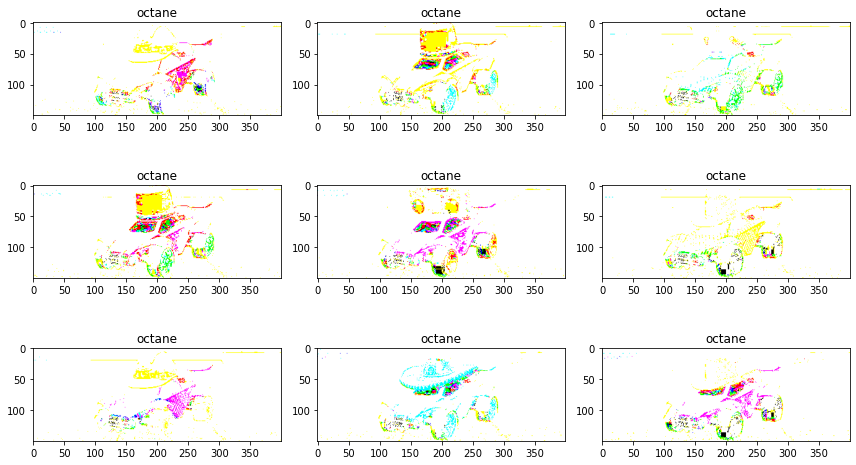

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# Randomisation des indices et affichage de 9 images alétoires de la base d'apprentissage
indices = np.arange(x.shape[0])
np.random.shuffle(indices)

plt.figure(figsize=(12, 7))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.title(CLASSES[int(y[i])])
    plt.imshow(x[i])

plt.tight_layout()
plt.show()